In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
from scipy.interpolate import CubicSpline

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# Cubic spline Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(0, 4):
            value = column.at[i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = prev_valid_index(column, i)
                end_first = next_valid_index(column, i)
                gap = list(range(start_first + 1, end_first))
                linear_a = (column.at[end_first] - column.at[start_first])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            value = column.at[size - 4 + i]
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, size - 4 + i)
                end_last = next_valid_index(column, size - 4 + i)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[size - 4 + i] = linear_a*i + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, len(nearest_indexes) - 1)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def cubic_spline_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                cubic_spline = CubicSpline(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = cubic_spline(x)
                plot_polynomial(cubic_spline, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()

In [7]:
def read_csv_replace_missing_by_polynomial(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=1)
        df = df.iloc[:, 2:-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 2:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_filler(df[col])
                df[col] = polynomial_filler(df[col]) 
            i += 1
        return df

In [9]:
df = read_csv_replace_missing_by_polynomial('idh_longevidade.csv')
df = df.T
df
header = df.iloc[0]
df = df[1:]
df.columns = header
df

Estado,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1991,0.623,0.543,0.627,0.613,0.601,0.595,0.674,0.647,0.636,0.596,...,0.663,0.642,0.593,0.62,0.613,0.685,0.691,0.58,0.673,0.631
2012,0.791,0.749,0.764,0.796,0.79,0.796,0.865,0.863,0.807,0.739,...,0.846,0.832,0.827,0.758,0.752,0.86,0.878,0.775,0.863,0.785
2013,0.797,0.756,0.769,0.801,0.794,0.801,0.87,0.87,0.81,0.744,...,0.852,0.837,0.831,0.762,0.757,0.865,0.885,0.779,0.869,0.79
2014,0.804,0.763,0.773,0.806,0.799,0.804,0.875,0.876,0.813,0.749,...,0.857,0.843,0.836,0.765,0.763,0.87,0.89,0.784,0.875,0.795
2015,0.809,0.769,0.777,0.811,0.803,0.808,0.879,0.882,0.815,0.754,...,0.862,0.848,0.84,0.769,0.768,0.875,0.896,0.788,0.88,0.8
2016,0.815,0.776,0.781,0.815,0.807,0.812,0.884,0.887,0.818,0.759,...,0.867,0.853,0.844,0.772,0.774,0.88,0.902,0.793,0.885,0.805
2017,0.82,0.782,0.785,0.82,0.811,0.816,0.888,0.892,0.821,0.764,...,0.872,0.858,0.848,0.775,0.779,0.884,0.907,0.797,0.889,0.809
2018,0.825,0.788,0.789,0.824,0.815,0.819,0.892,0.897,0.824,0.769,...,0.877,0.863,0.851,0.778,0.784,0.888,0.912,0.801,0.894,0.814
2019,0.83,0.793,0.792,0.828,0.818,0.823,0.896,0.902,0.827,0.773,...,0.882,0.867,0.855,0.781,0.788,0.893,0.916,0.805,0.898,0.818


In [10]:
df['Ano'] = df.index
df = df.reset_index(drop=True)

missing_years = list(range(1981, 1991)) + list(range(1992, 2013))
for year in missing_years: 
    novo_ano = pd.Series({'Ano': year})
    df = df.append(novo_ano, ignore_index=True)
    
df['Ano'] = df['Ano'].astype(int)    
df = df.sort_values('Ano', ascending=True)
df = df.set_index('Ano')
df.to_csv('idh_para_interpolacao.csv', index=True)
df

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo,Tocantins
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.523,0.452,0.522,0.531,0.518,0.46,0.561,0.565,0.529,0.516,...,0.56,0.54,0.434,0.527,0.531,0.603,0.592,0.481,0.547,0.522
1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
def read_csv_replace_missing_by_polynomial_2(file_path):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path)
        df = df.iloc[:, :-1]
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = four_ends_linear_filler(df[col])
                df[col] = cubic_spline_filler(df[col]) 
            i += 1
        return df

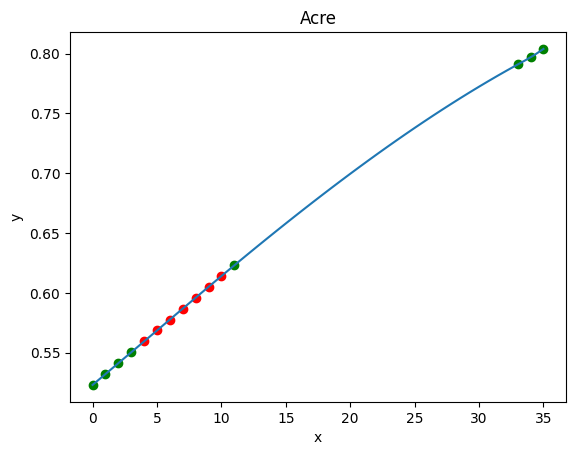

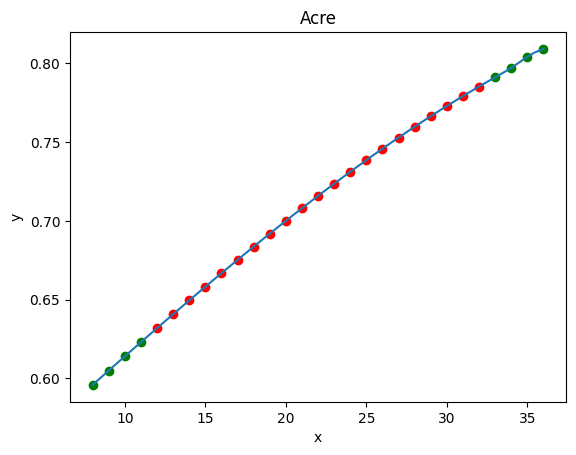

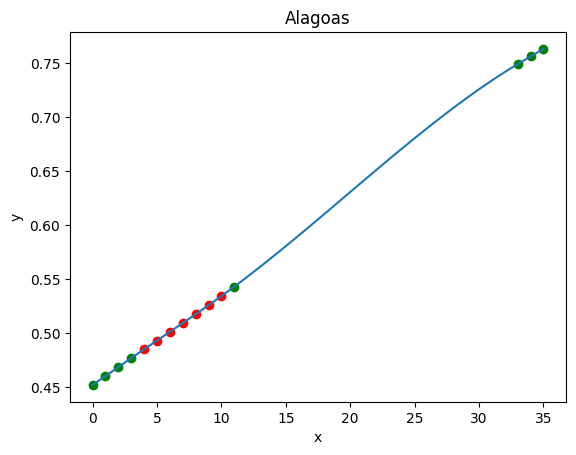

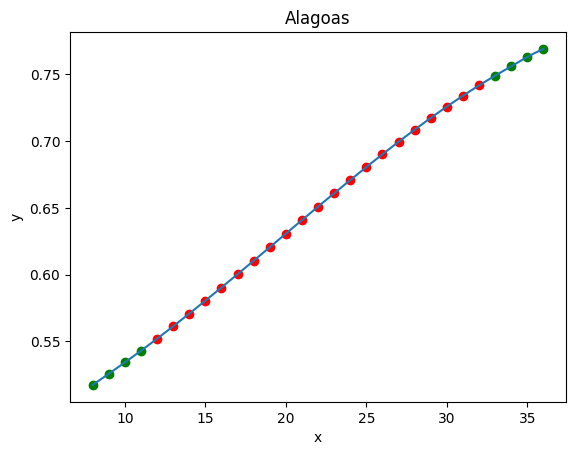

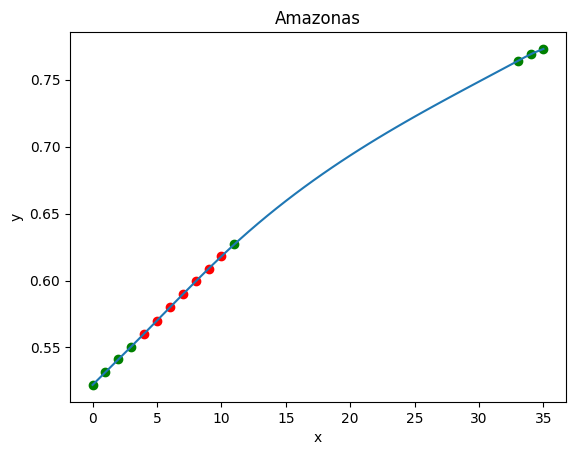

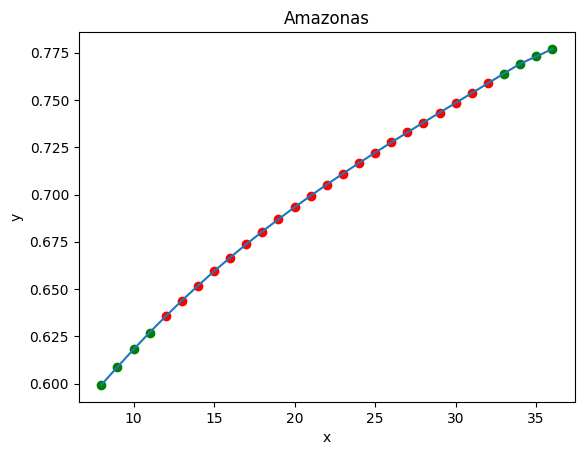

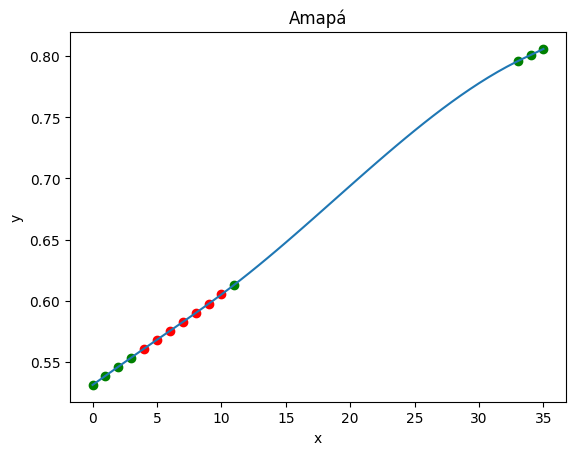

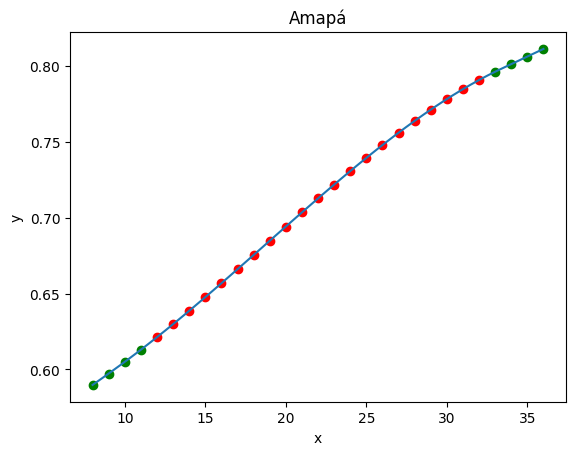

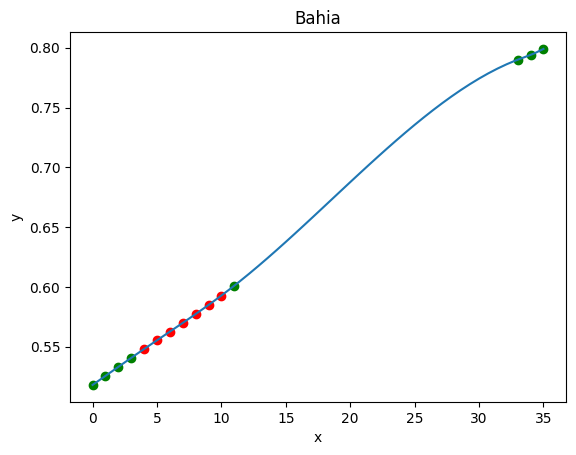

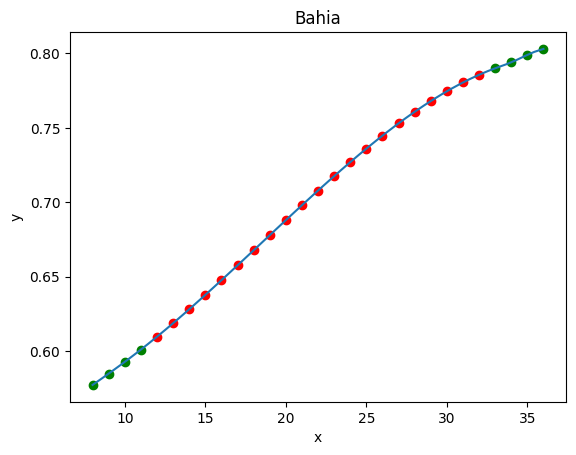

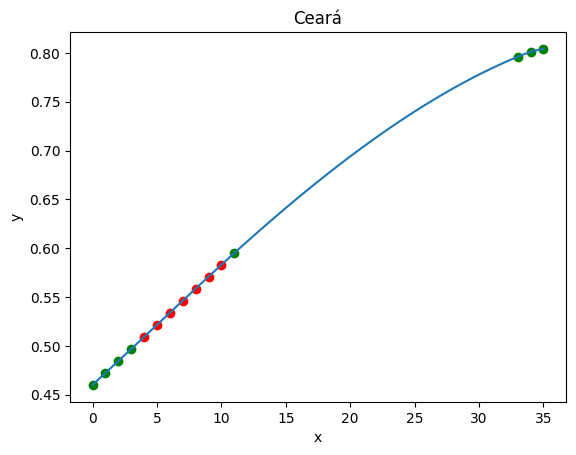

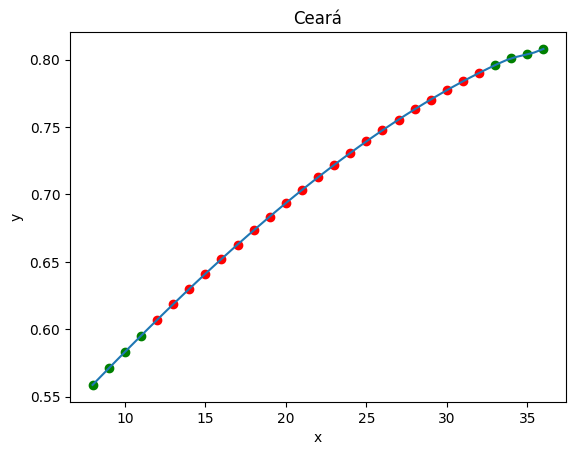

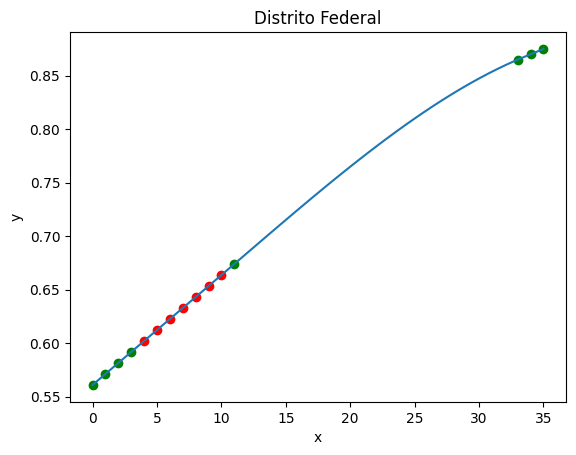

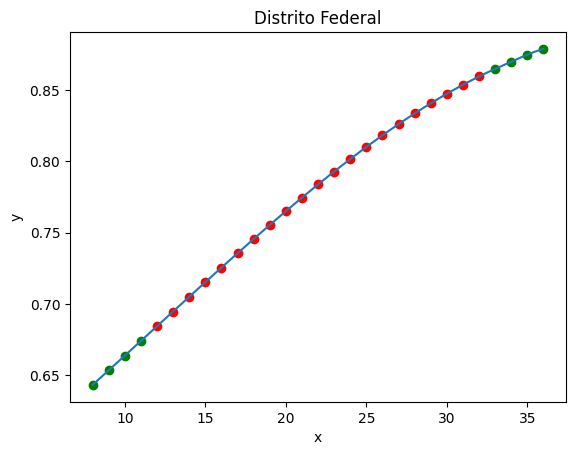

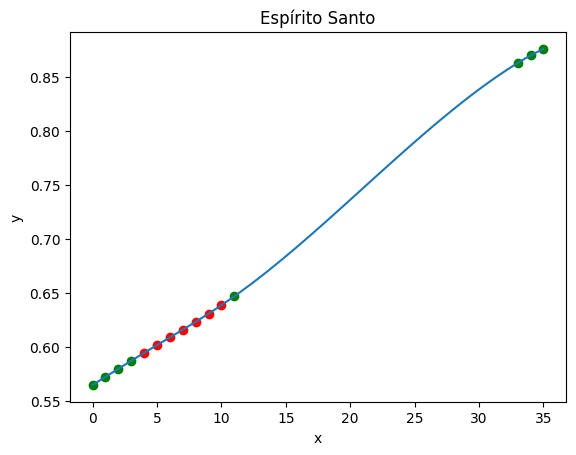

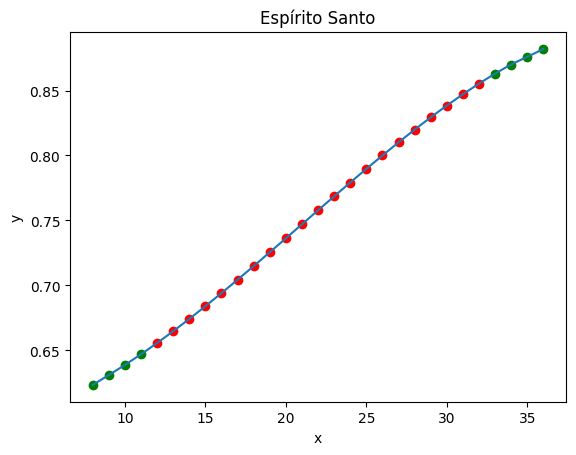

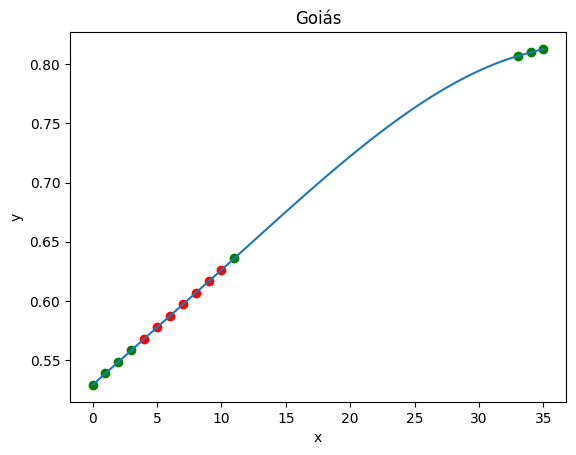

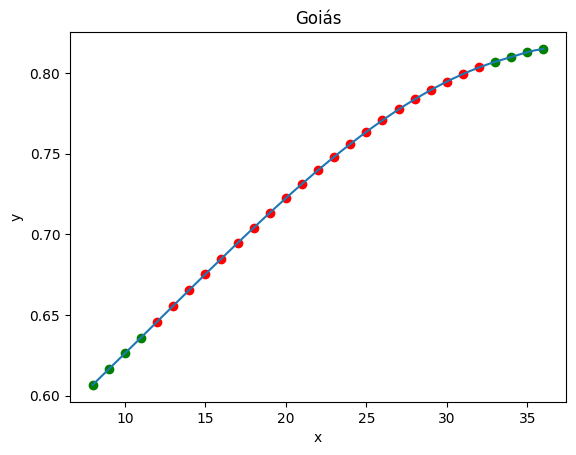

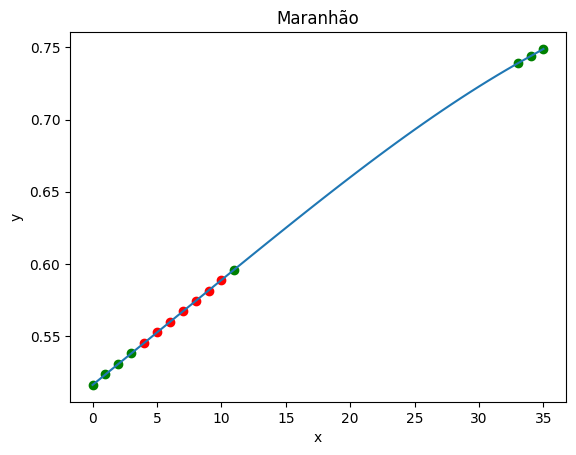

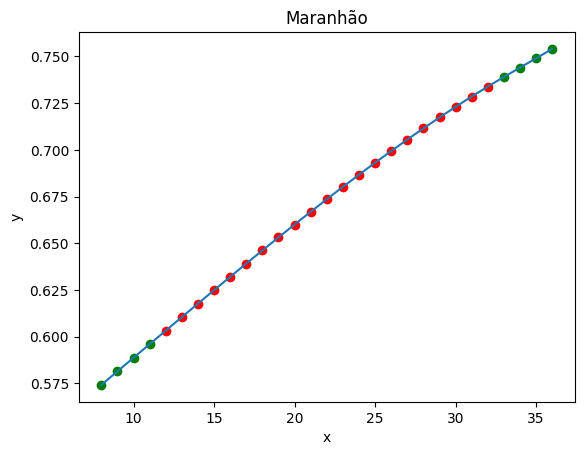

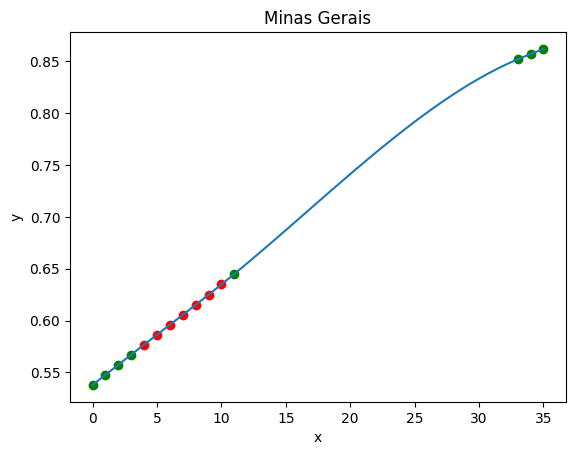

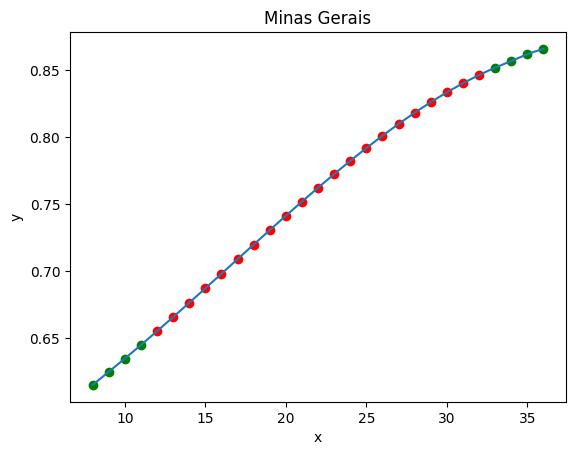

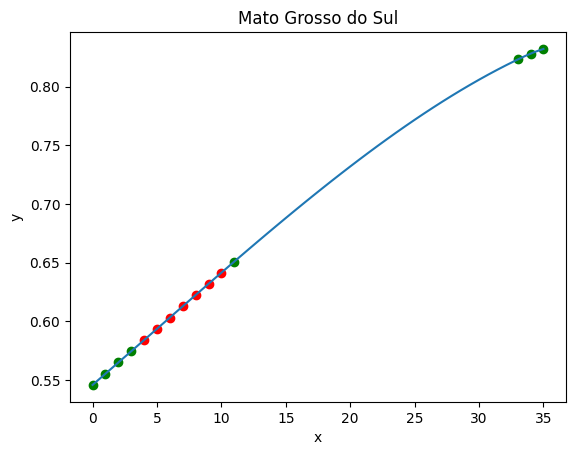

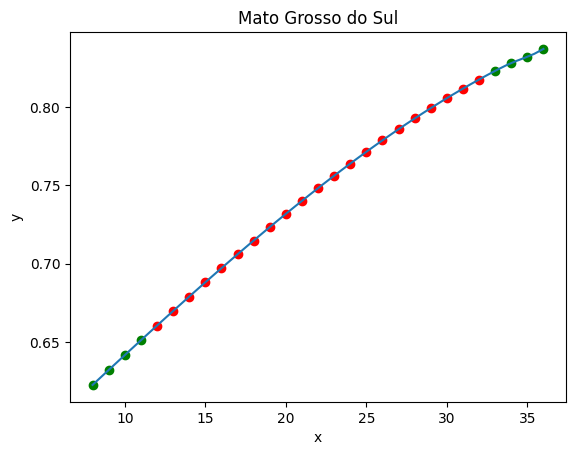

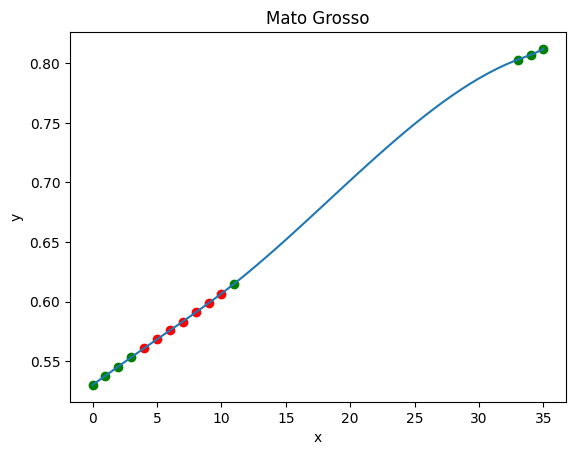

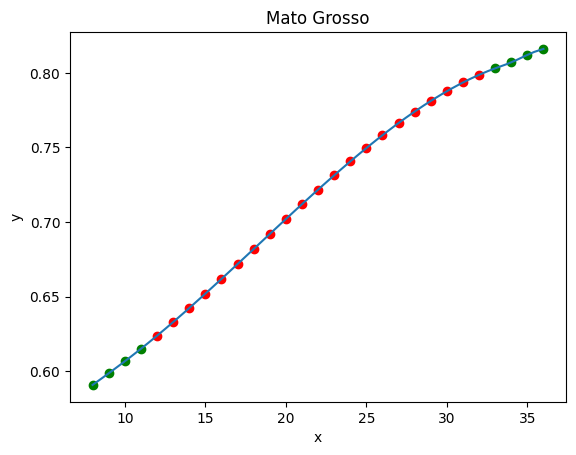

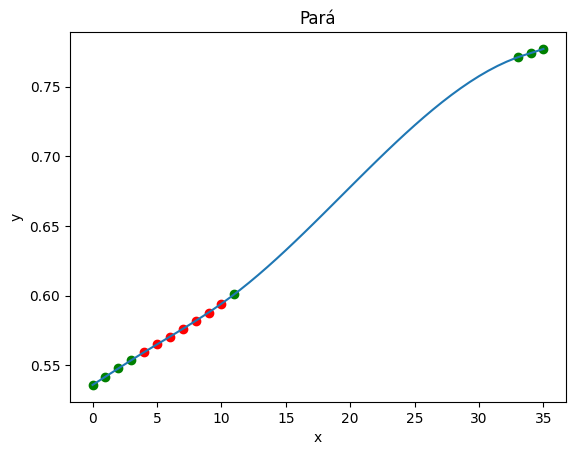

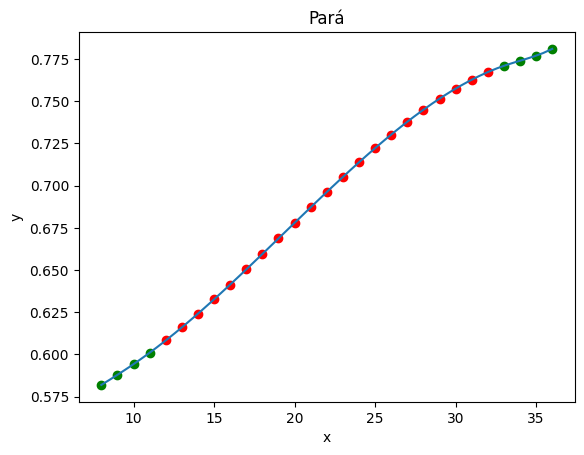

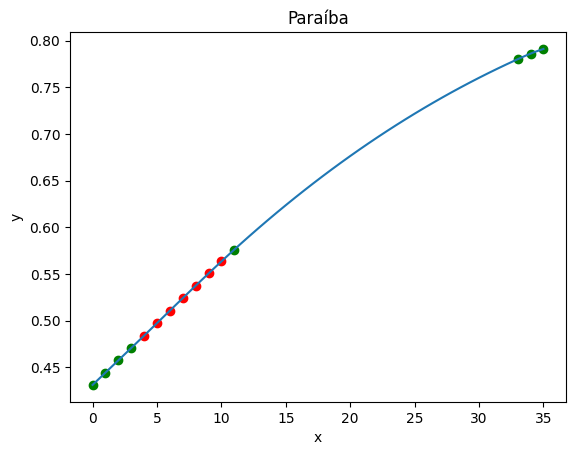

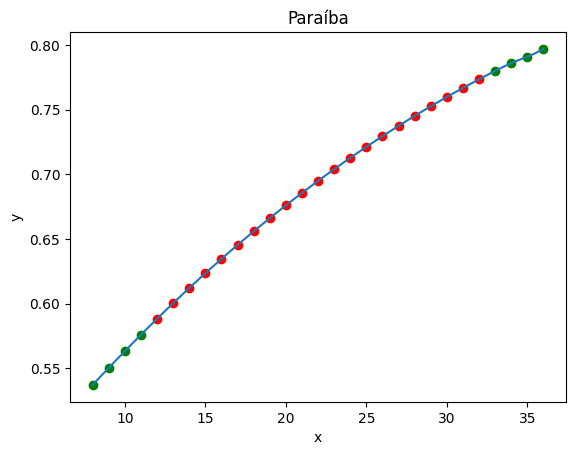

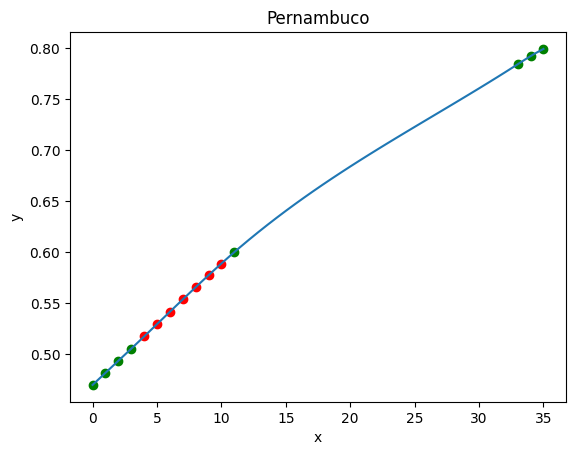

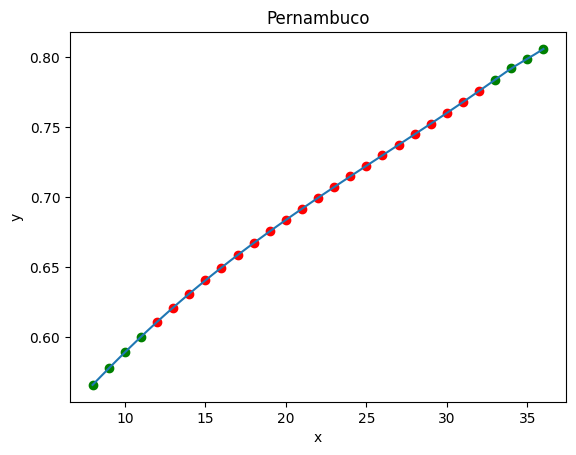

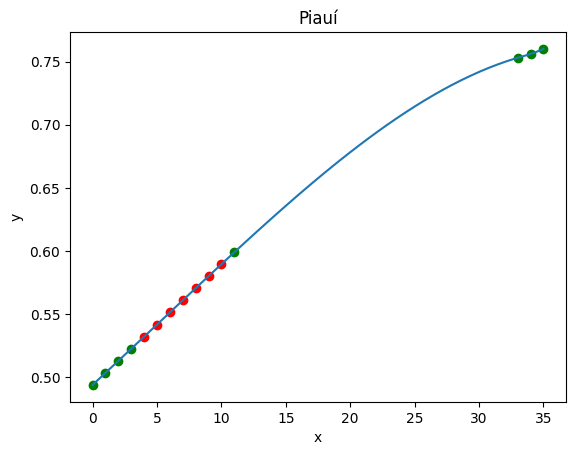

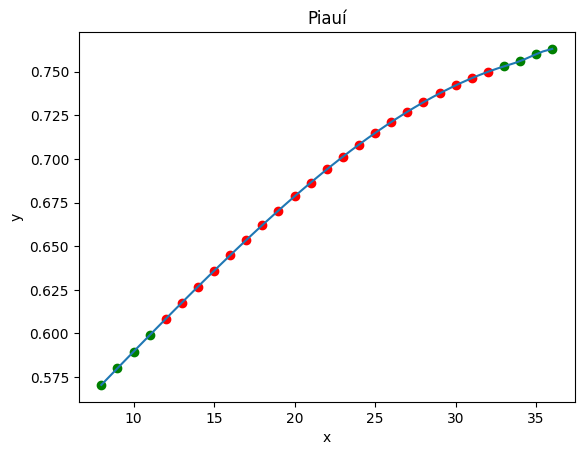

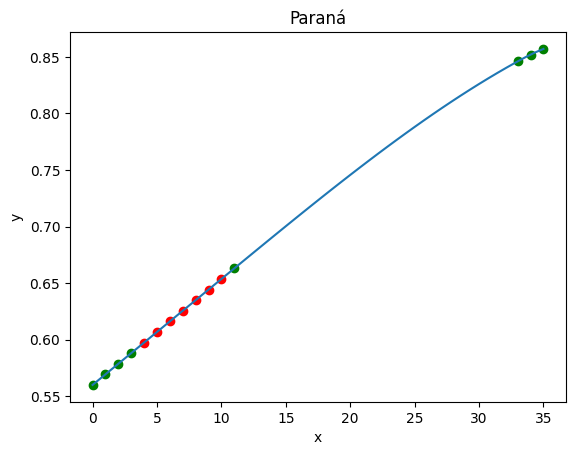

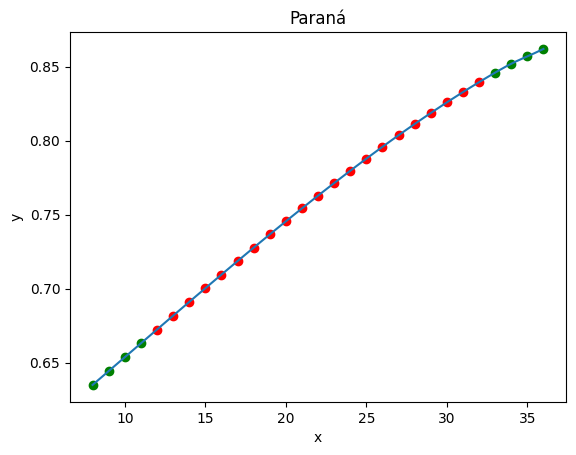

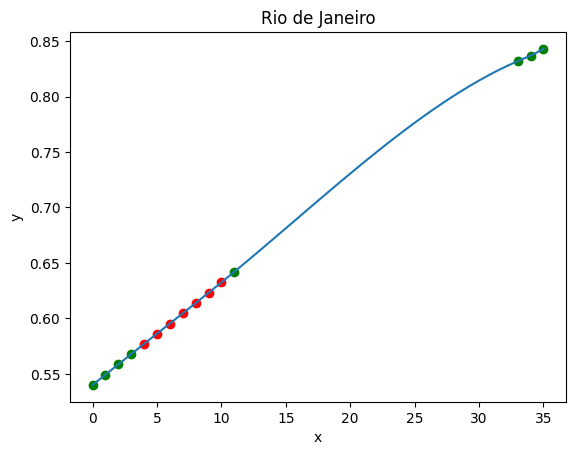

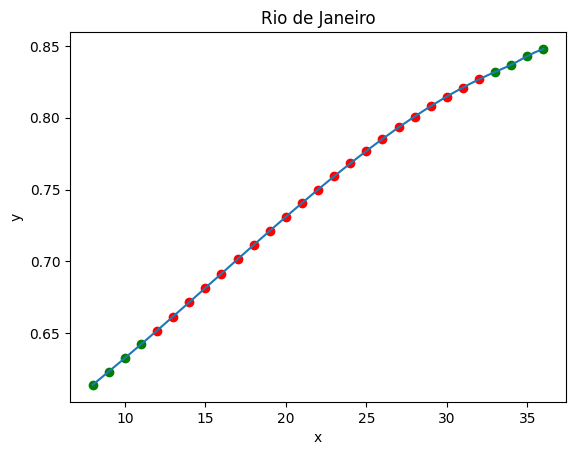

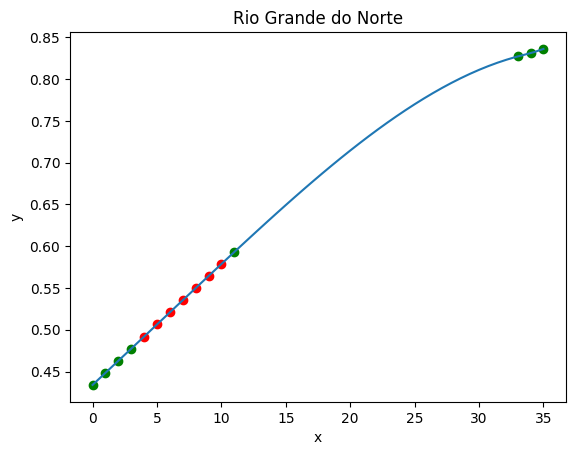

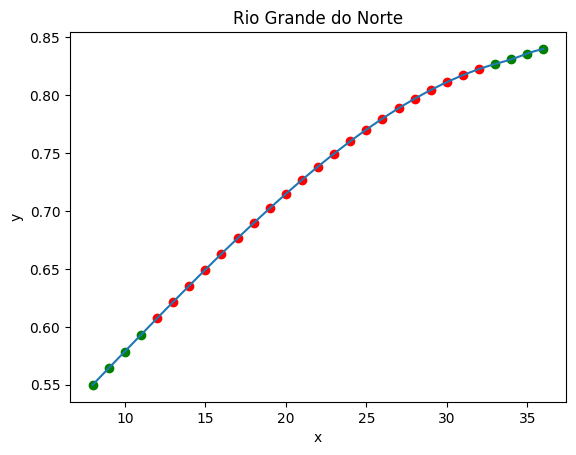

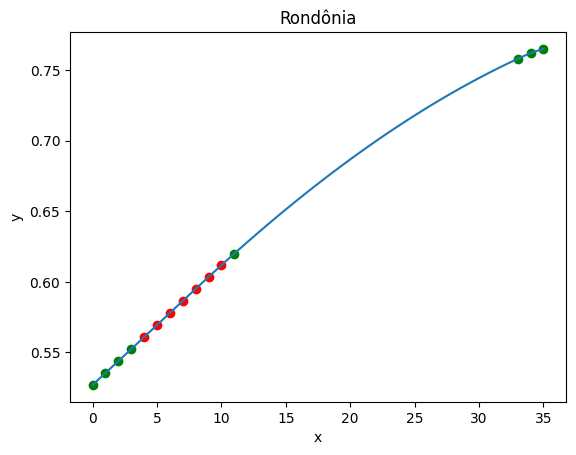

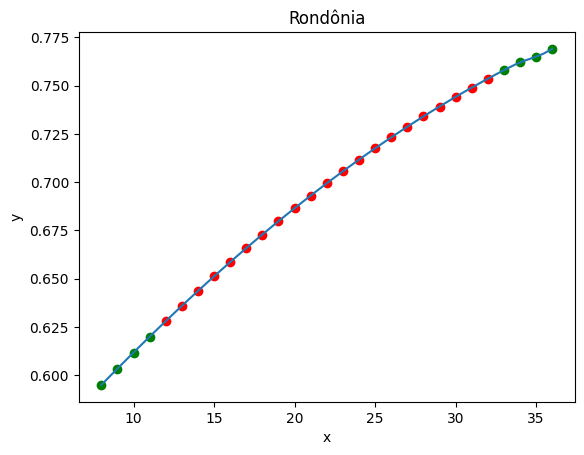

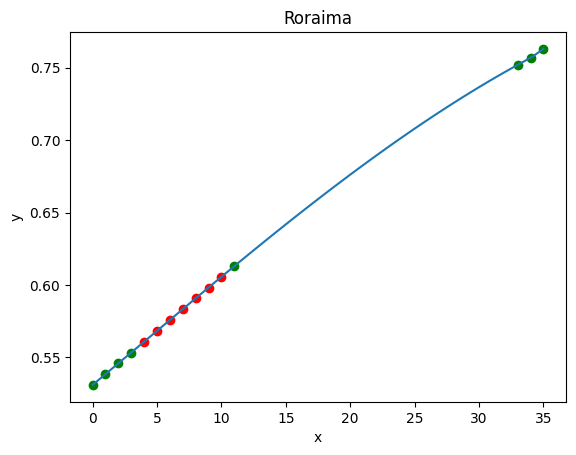

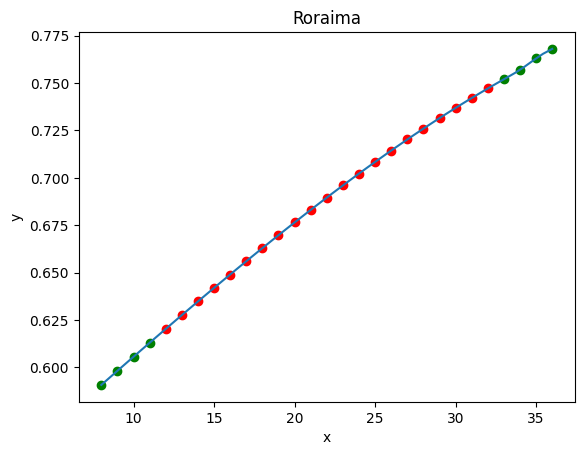

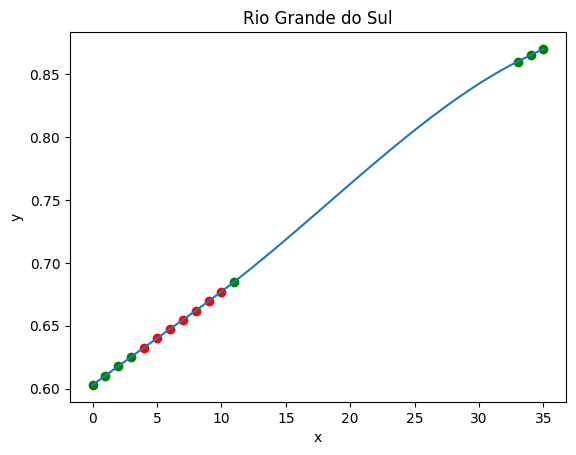

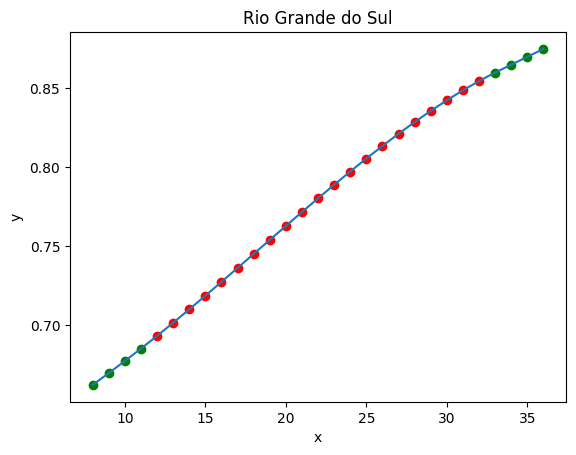

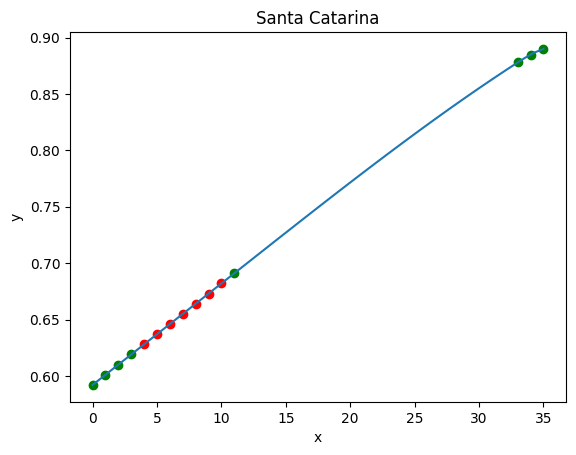

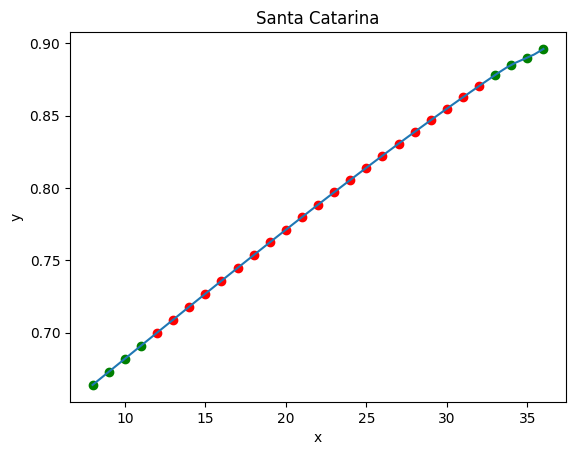

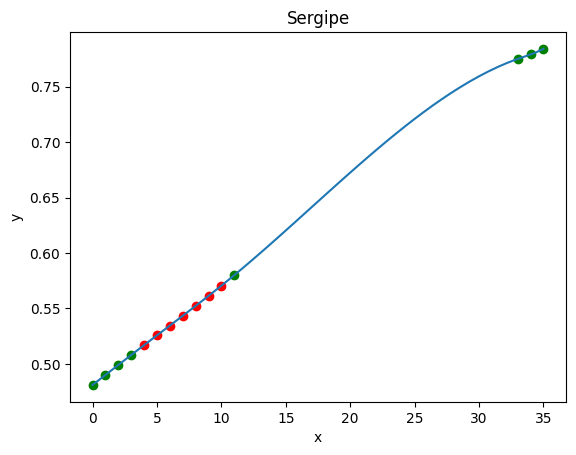

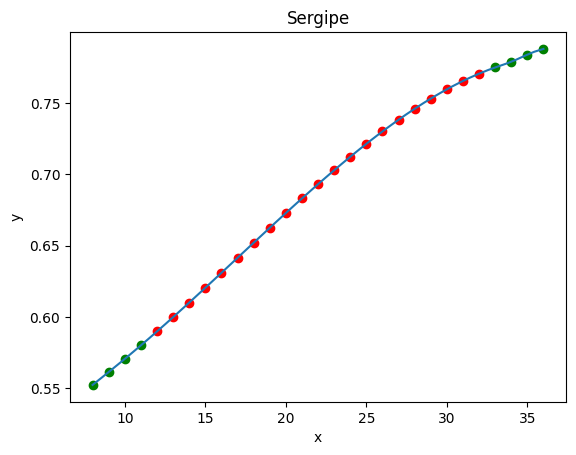

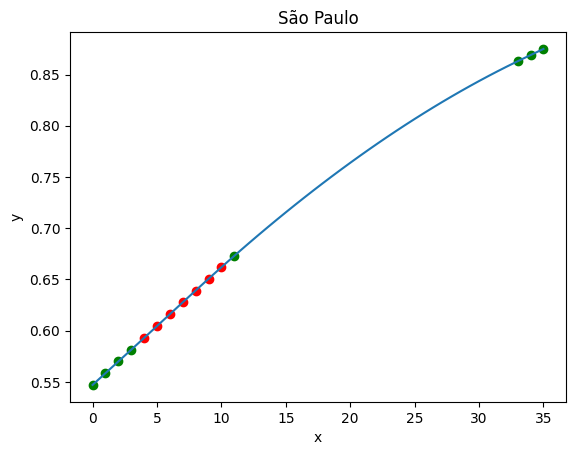

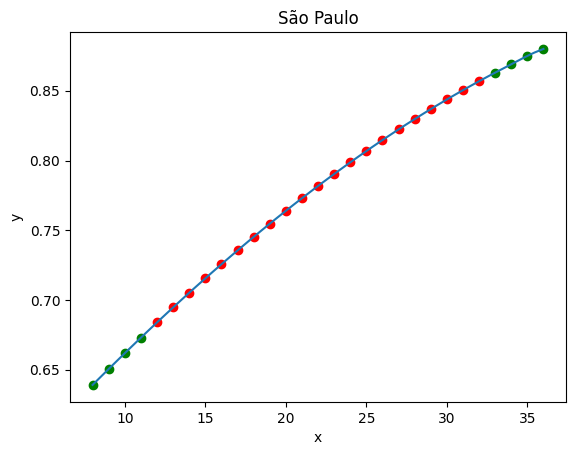

,Acre,Alagoas,Amazonas,Amapá,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,Maranhão,...,Piauí,Paraná,Rio de Janeiro,Rio Grande do Norte,Rondônia,Roraima,Rio Grande do Sul,Santa Catarina,Sergipe,São Paulo
Ano,,,,,,,,,,,,,,,,,,,,,
1980,0.523000,0.452000,0.522000,0.531000,0.518000,0.460000,0.561000,0.565000,0.529000,0.516000,...,0.494000,0.560000,0.540000,0.434000,0.527000,0.531000,0.603000,0.592000,0.481000,0.547000
1981,0.532091,0.460273,0.531545,0.538455,0.525545,0.472273,0.571273,0.572455,0.538727,0.523273,...,0.503545,0.569364,0.549273,0.448455,0.535455,0.538455,0.610455,0.601000,0.490000,0.558455
1982,0.541182,0.468545,0.541091,0.545909,0.533091,0.484545,0.581545,0.579909,0.548455,0.530545,...,0.513091,0.578727,0.558545,0.462909,0.543909,0.545909,0.617909,0.610000,0.499000,0.569909
1983,0.550273,0.476818,0.550636,0.553364,0.540636,0.496818,0.591818,0.587364,0.558182,0.537818,...,0.522636,0.588091,0.567818,0.477364,0.552364,0.553364,0.625364,0.619000,0.508000,0.581364
1984,0.559389,0.484996,0.560302,0.560714,0.548040,0.509147,0.602084,0.594663,0.567895,0.545093,...,0.532205,0.597455,0.577040,0.491842,0.560868,0.560836,0.632736,0.627998,0.516903,0.592885
1985,0.568526,0.493096,0.570066,0.567977,0.555327,0.521523,0.612343,0.601835,0.577597,0.552370,...,0.541794,0.606820,0.586221,0.506341,0.569414,0.568324,0.640042,0.636993,0.525726,0.604461
1986,0.577670,0.501170,0.579863,0.575212,0.562575,0.533913,0.622601,0.608964,0.587295,0.559648,...,0.551389,0.616185,0.595388,0.520846,0.577974,0.575817,0.647325,0.645988,0.534523,0.616055
1987,0.586807,0.509271,0.589626,0.582478,0.569864,0.546288,0.632860,0.616138,0.596997,0.566925,...,0.560977,0.625550,0.604569,0.535344,0.586519,0.583304,0.654632,0.654983,0.543348,0.627629
1988,0.595922,0.517452,0.599288,0.589831,0.577272,0.558615,0.643126,0.623443,0.606710,0.574200,...,0.570545,0.634915,0.613793,0.549822,0.595022,0.590776,0.662008,0.663981,0.552254,0.639148


In [12]:
df = read_csv_replace_missing_by_polynomial_2('idh_para_interpolacao.csv')
df = df.set_index('Ano')
df

In [13]:
def plot_column(column, color):
    plt.figure(figsize=(12, 6))
    plt.plot(column.index, column.values, color=color)
    plt.xlabel(column.index.name)
    plt.ylabel('IDH - educação')
    plt.title(column.name)  # Set the column name as the graph title
    plt.xticks(rotation=45)
    plt.show()

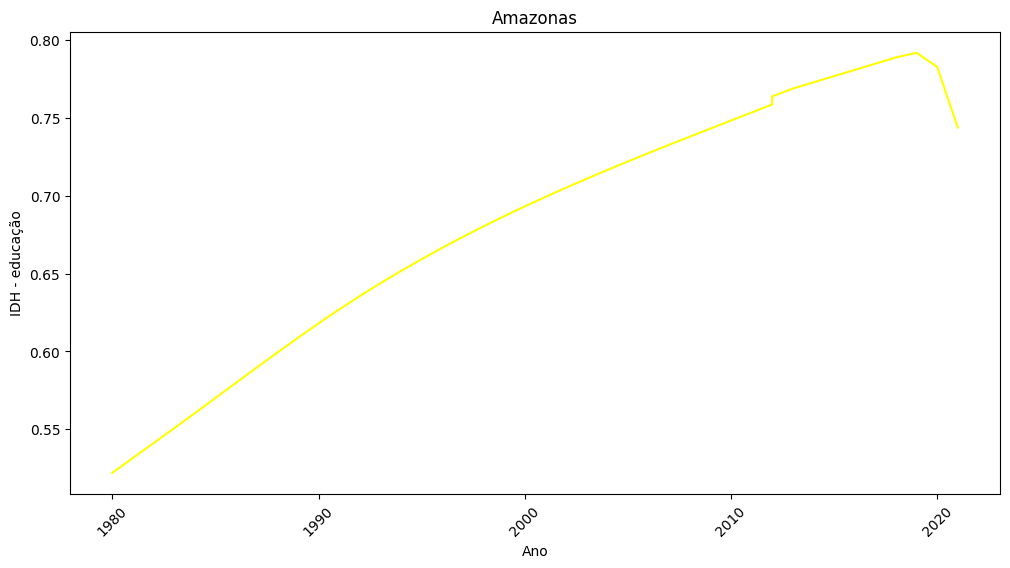

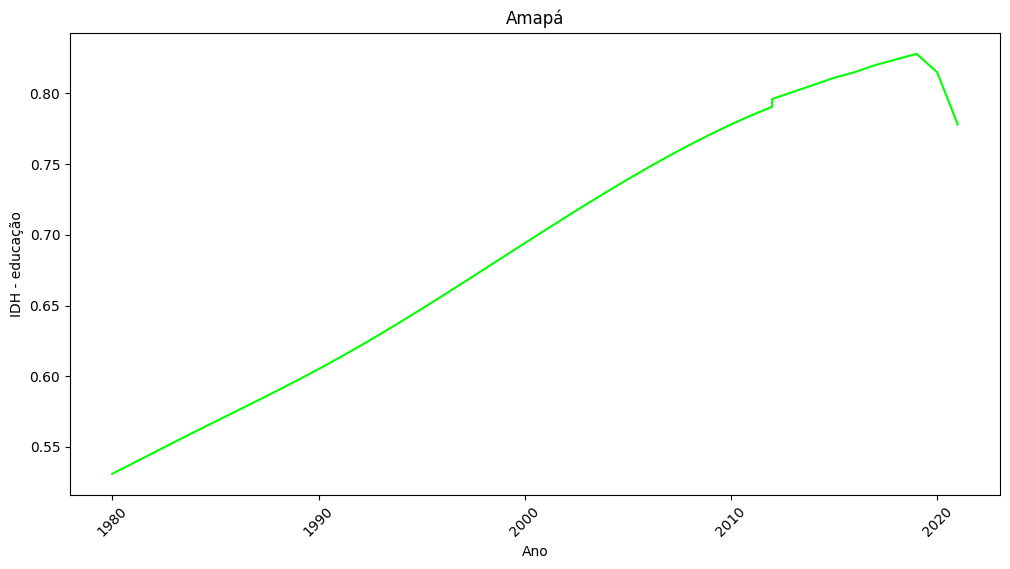

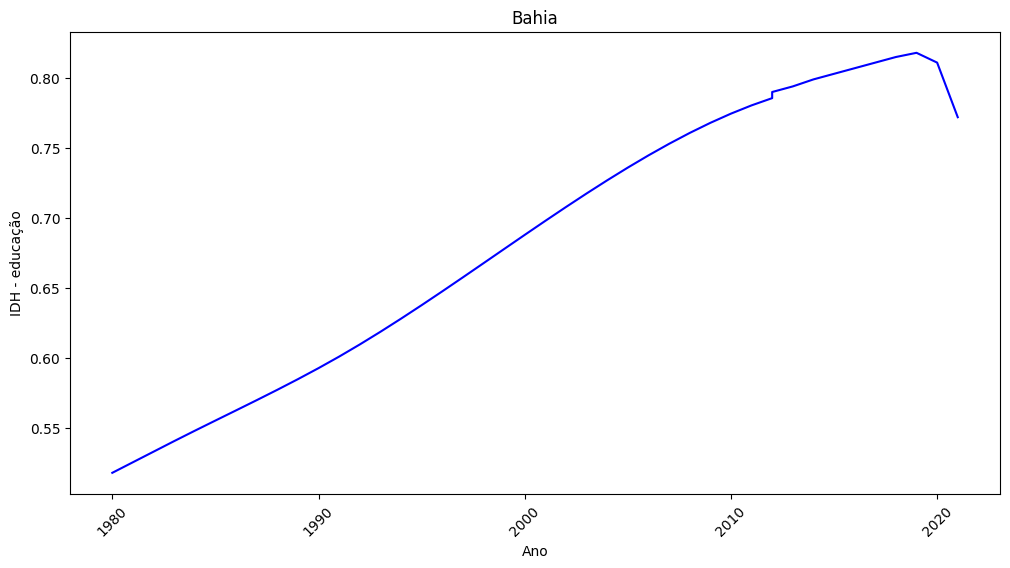

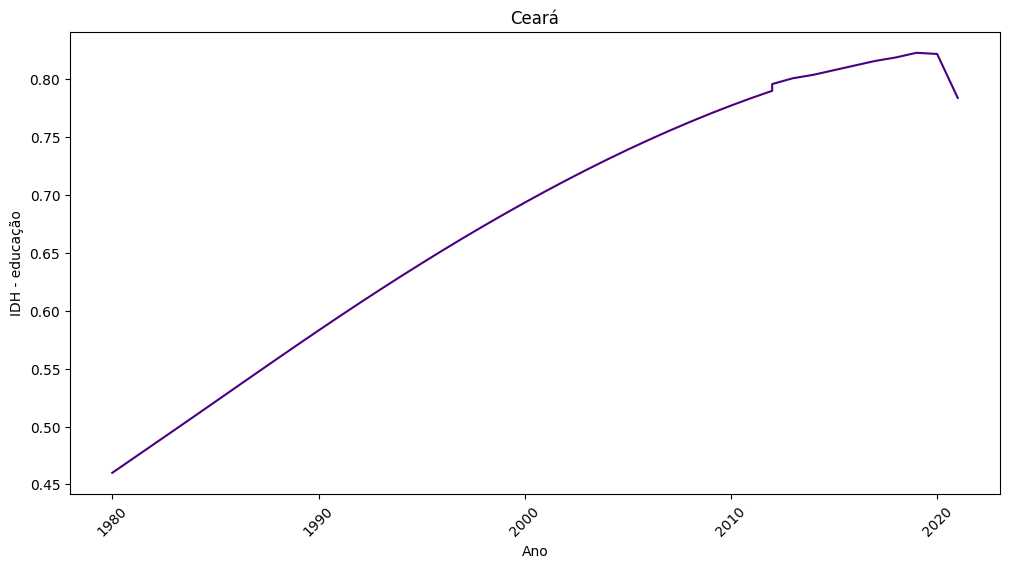

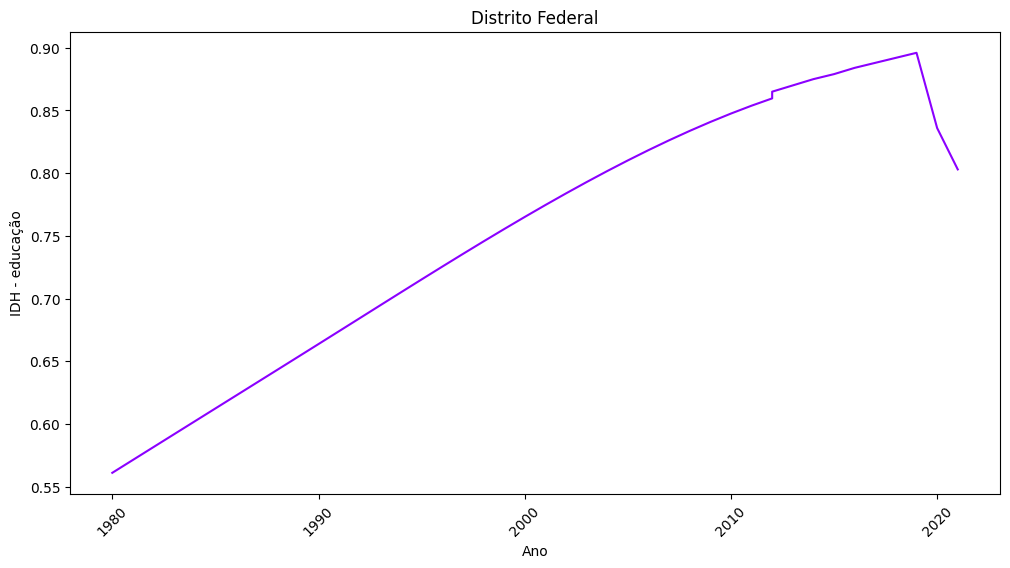

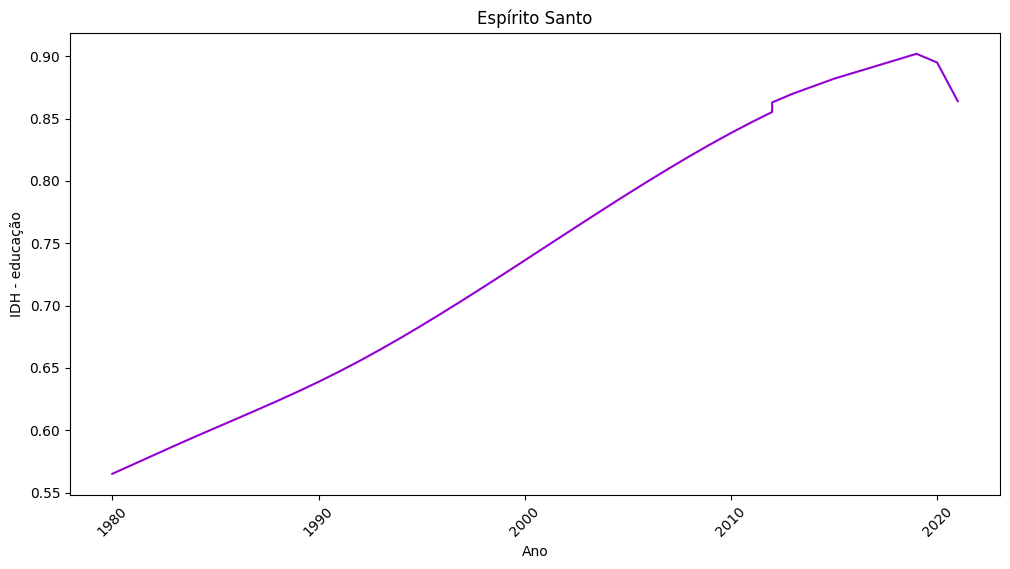

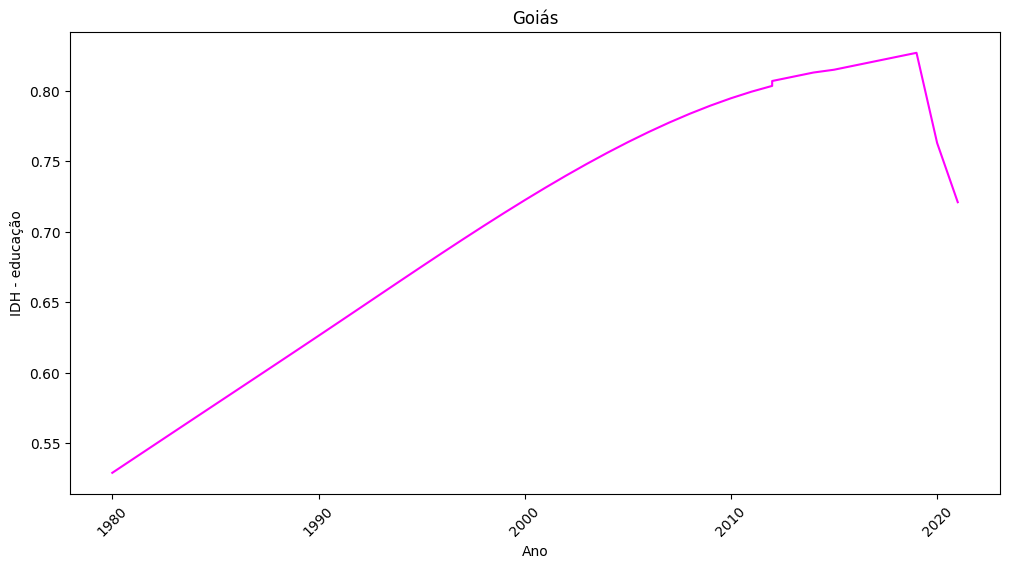

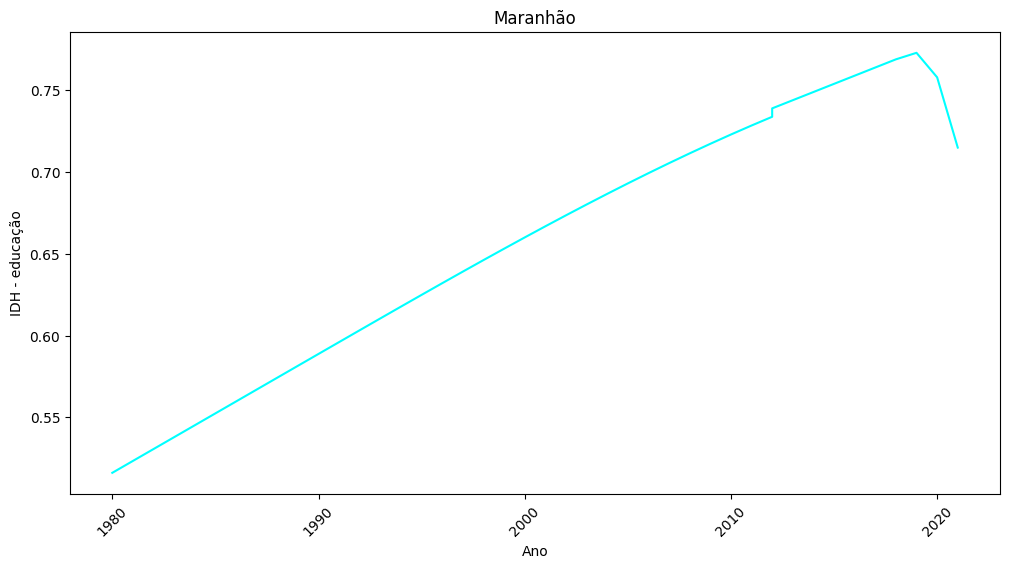

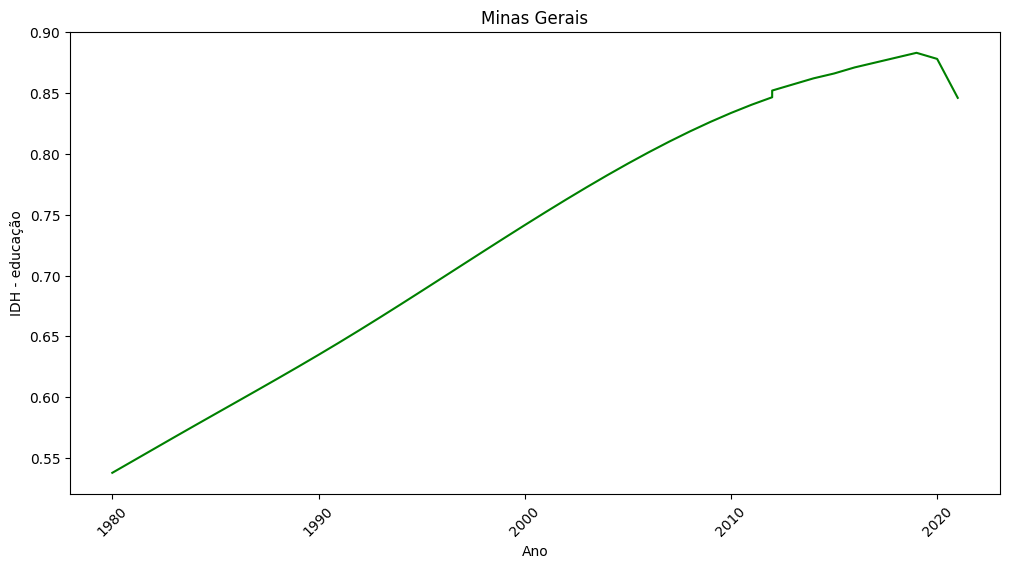

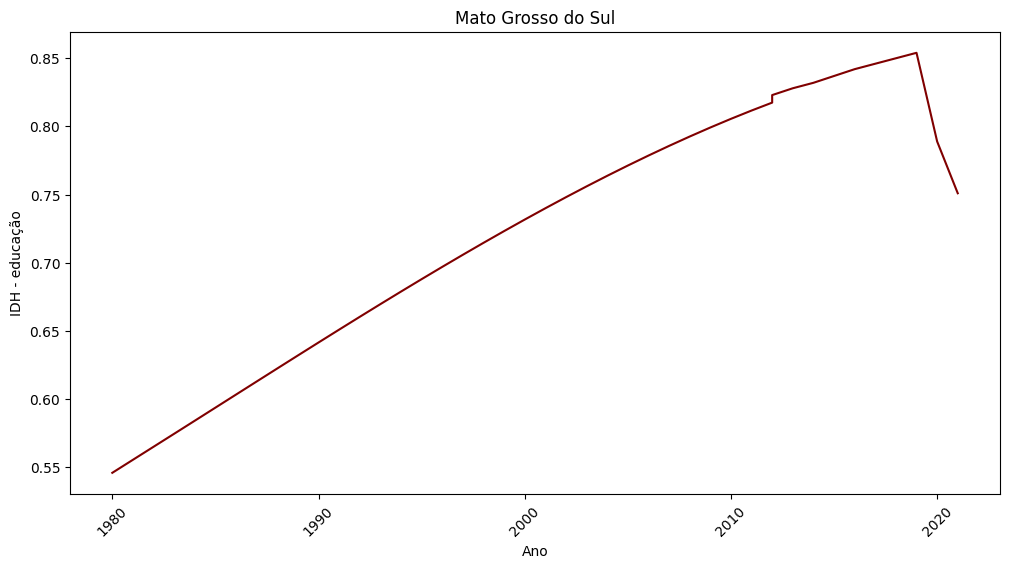

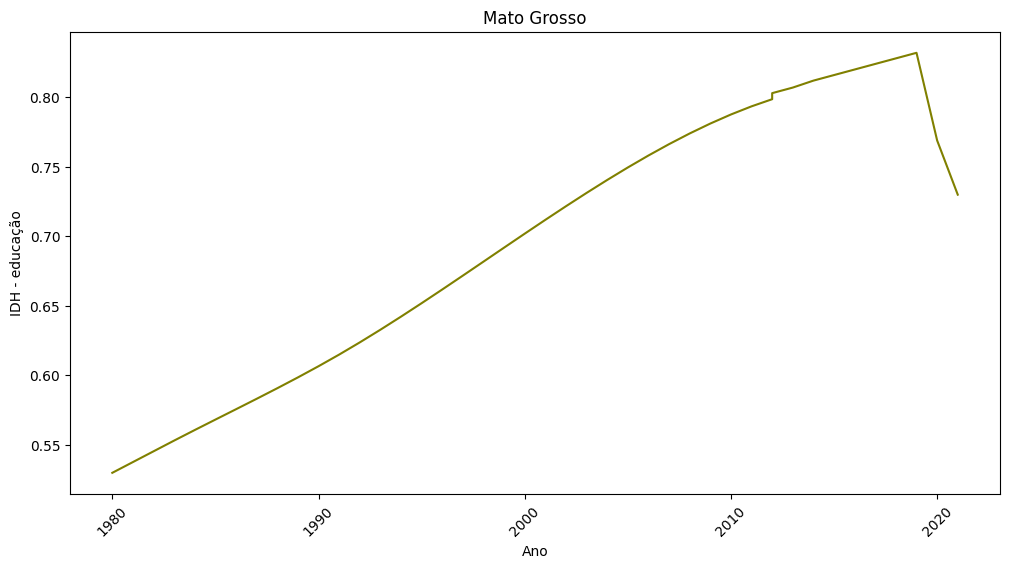

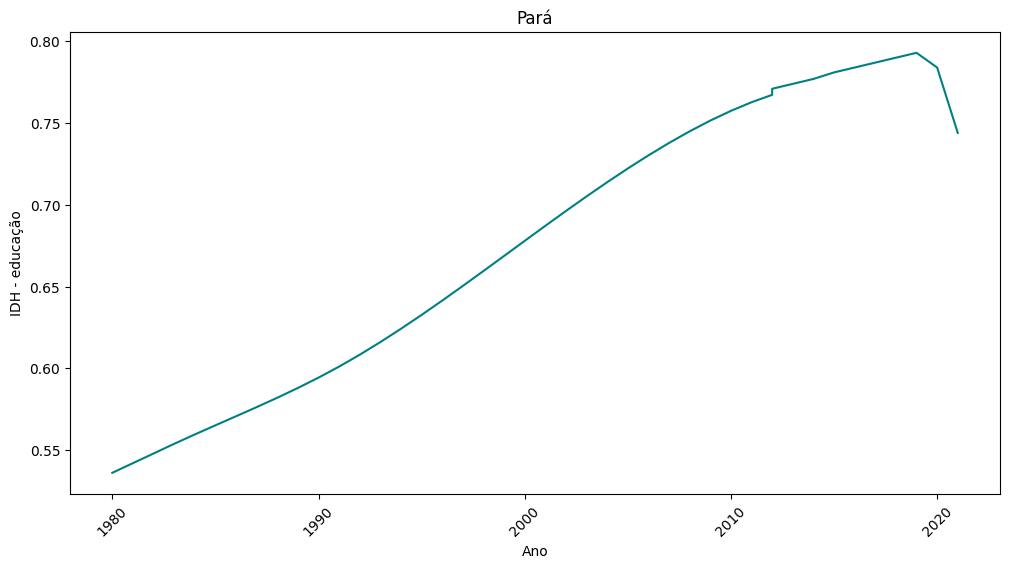

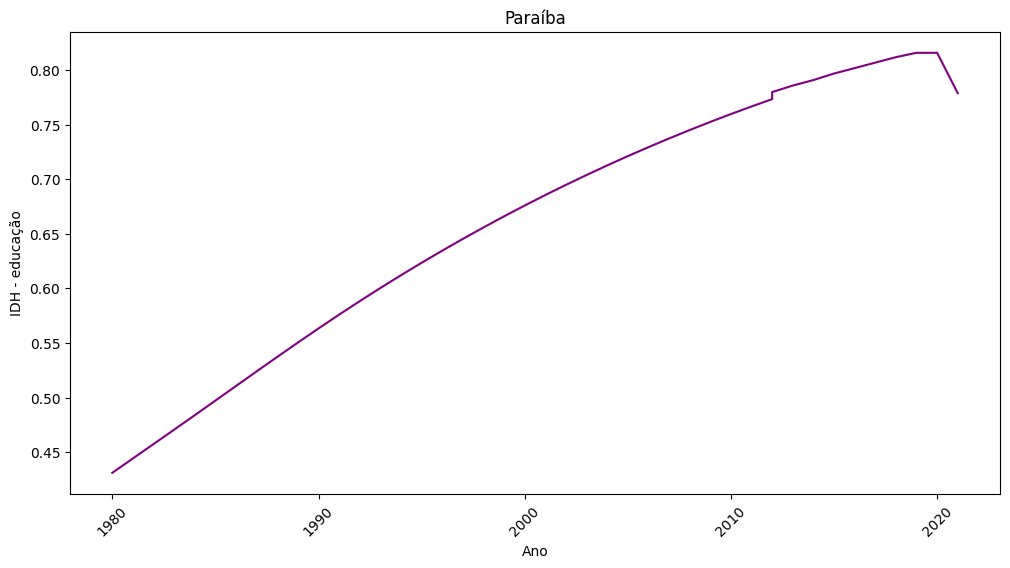

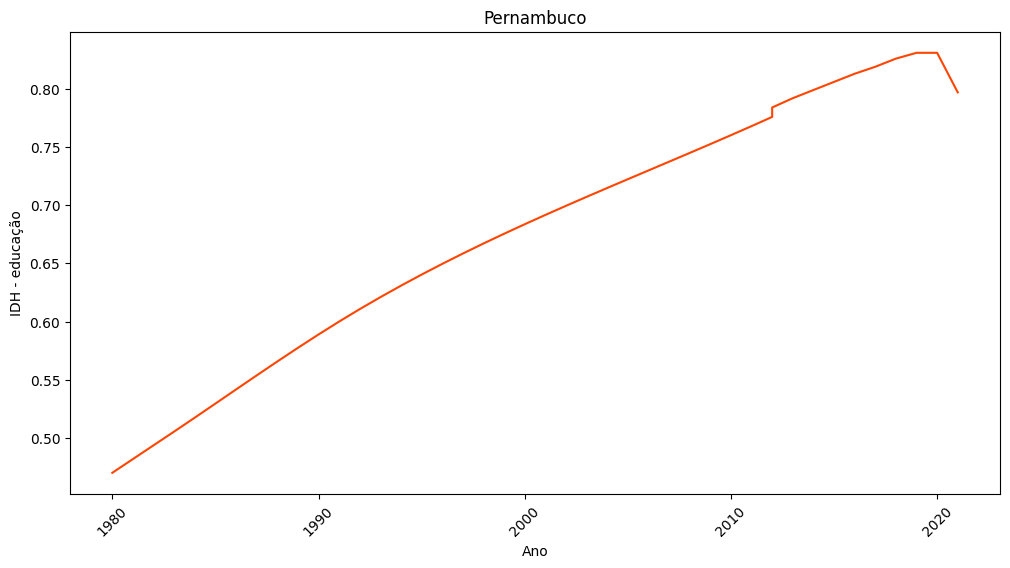

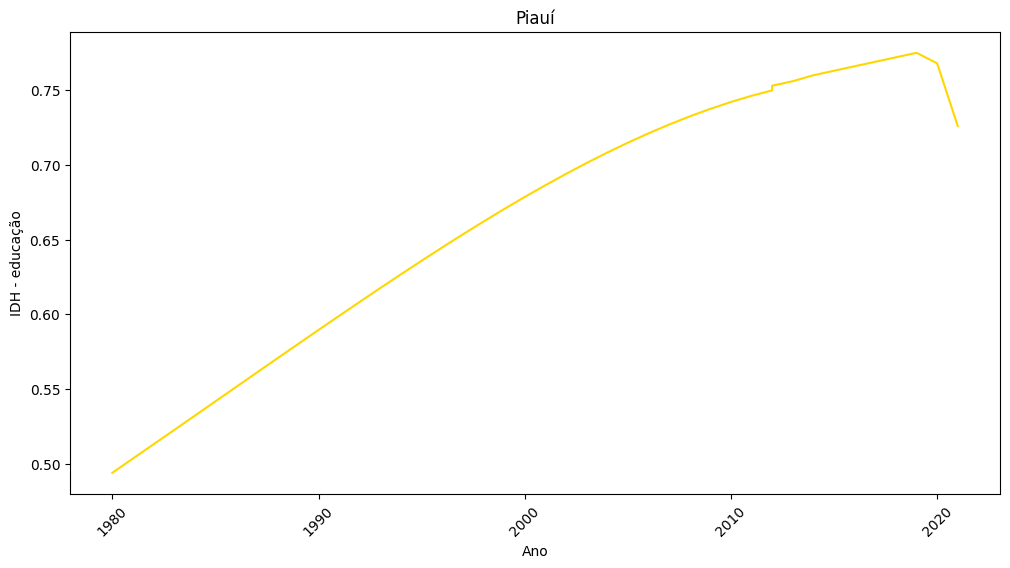

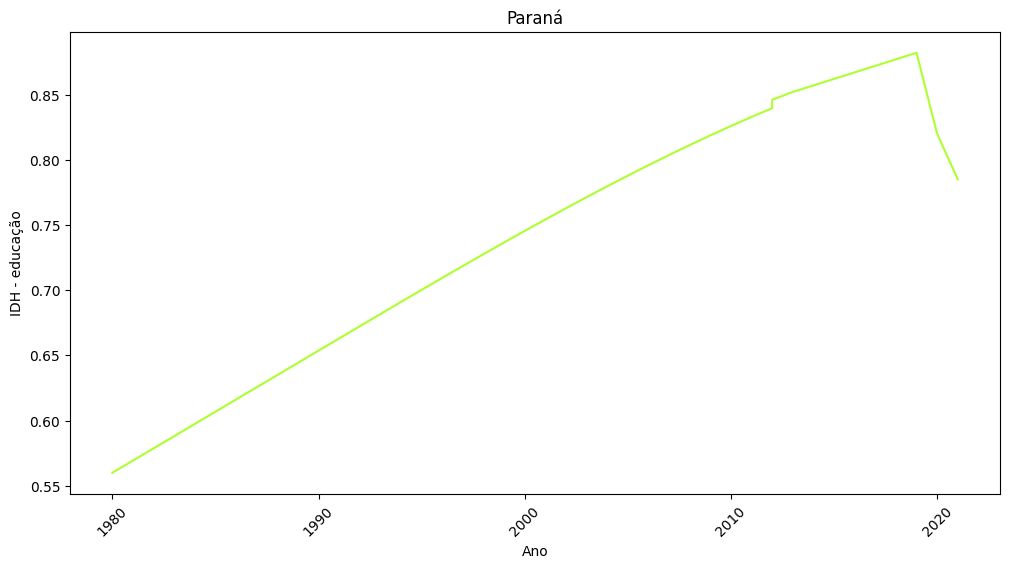

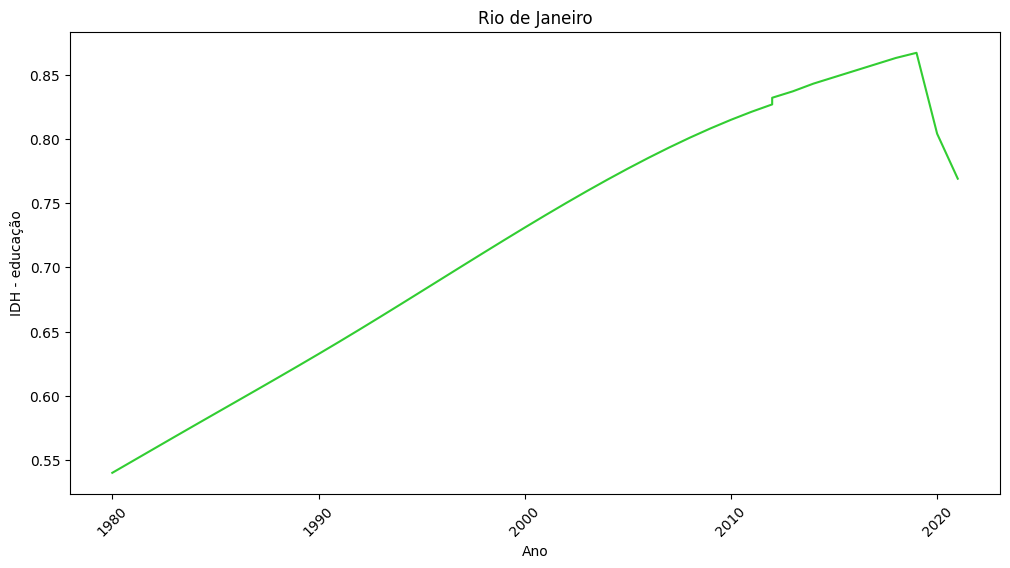

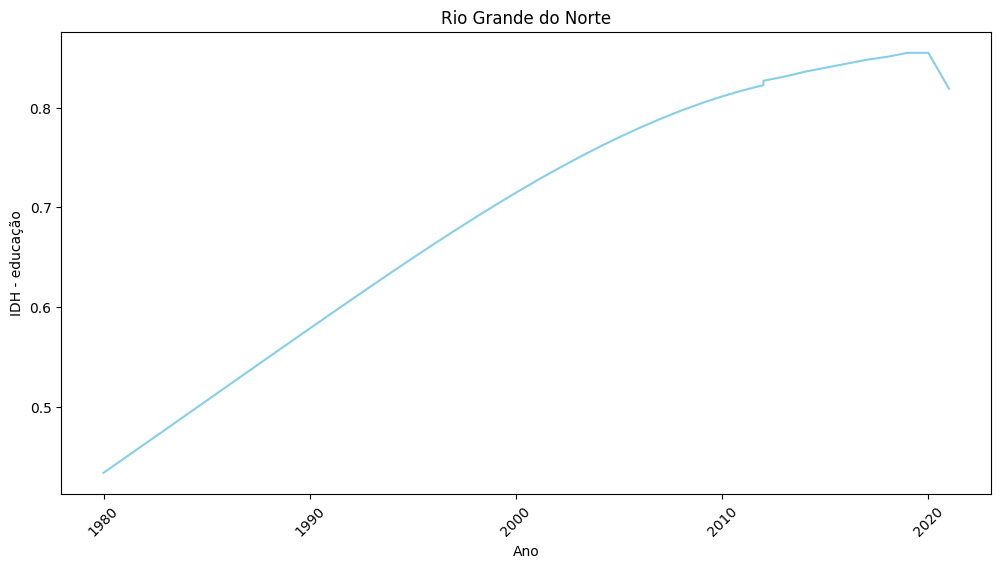

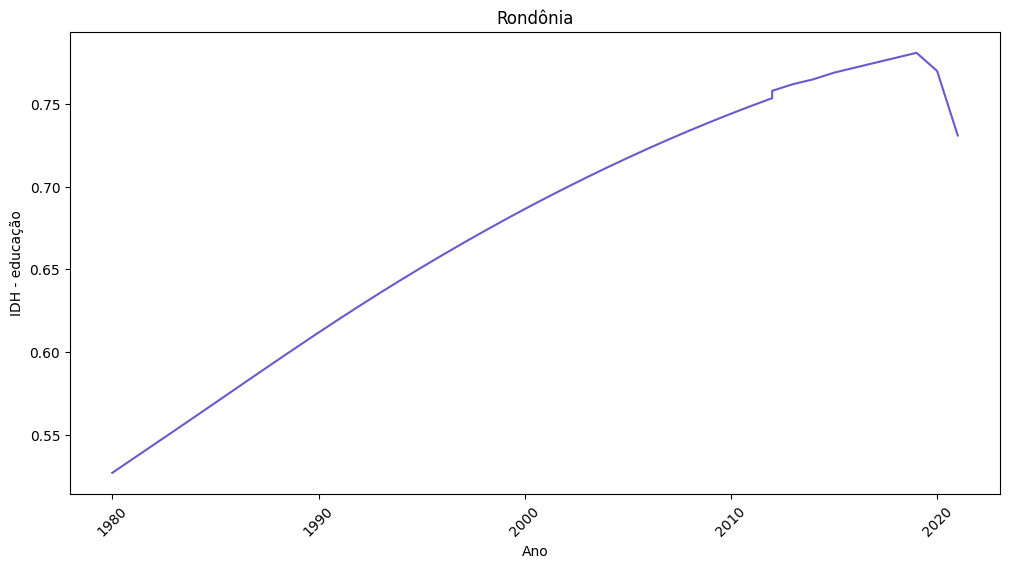

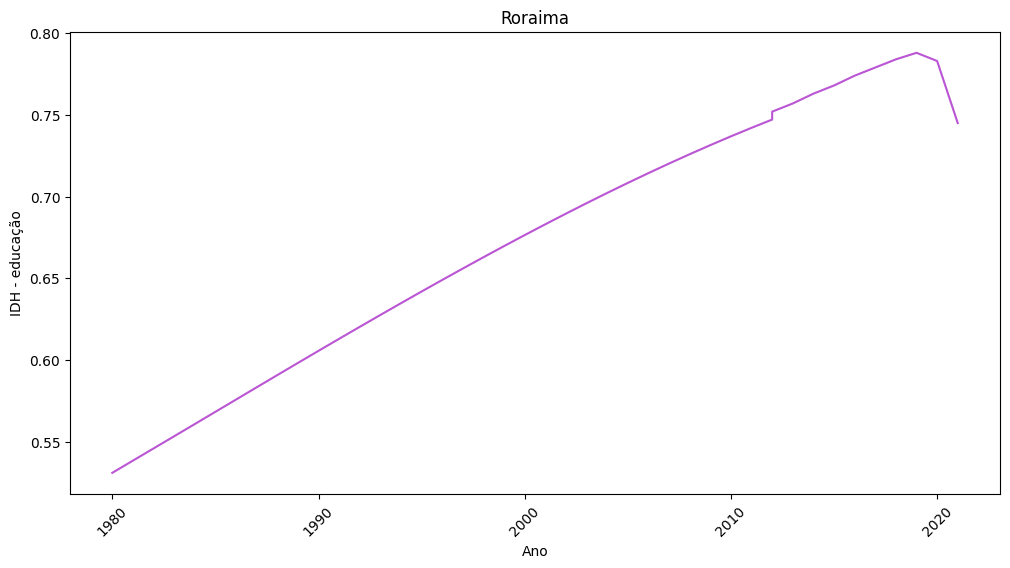

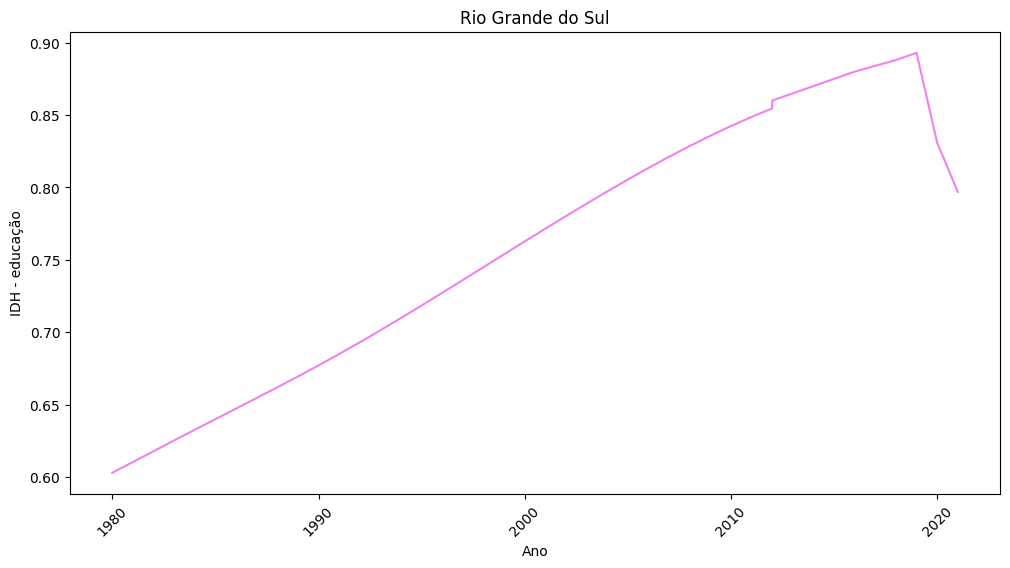

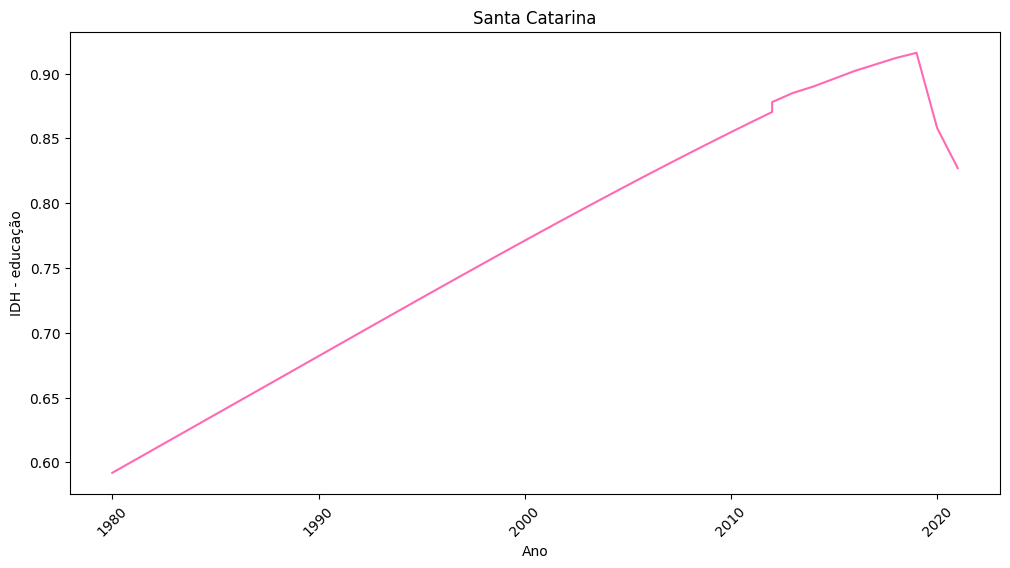

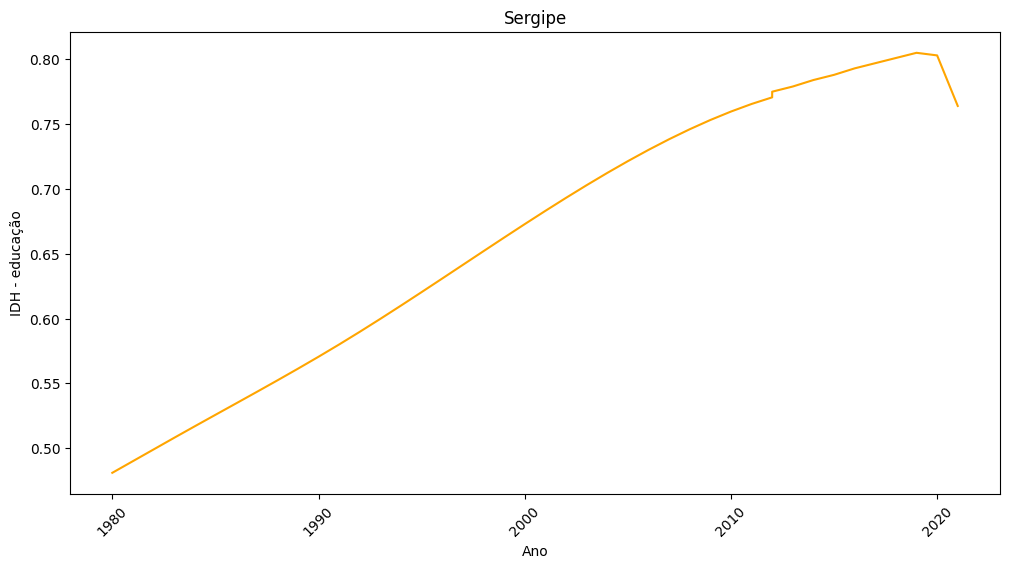

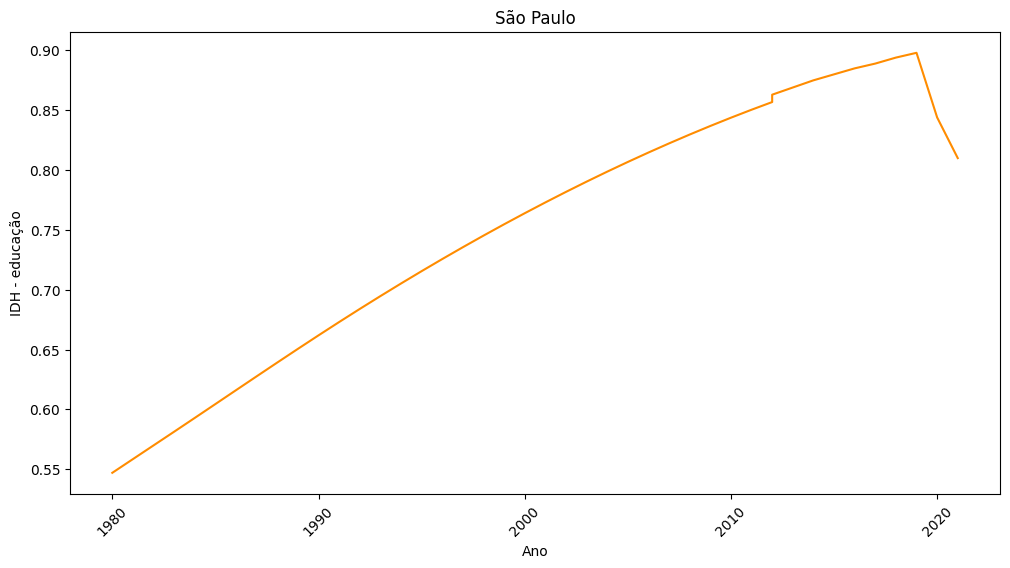

In [14]:
colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082', '#8B00FF', '#9400D3', '#FF00FF',
          '#00FFFF', '#008000', '#800000', '#808000', '#008080', '#800080', '#FF4500', '#FFD700', '#ADFF2F',
          '#32CD32', '#87CEEB', '#6A5ACD', '#BA55D3', '#EE82EE', '#FF69B4', '#FFA500', '#FF8C00', '#7FFFD4',
          '#00CED1']

for i, column in enumerate(df.columns):
    if i > 1:
        plot_column(df[column], color=colors[i])